In [11]:
from copy import deepcopy
import csv
from functools import partial
import itertools as itt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA

The `data` dataframe will only be used when initially loading the CSV file

In [6]:
file_path = 'rates.csv'
data = pd.read_csv(file_path, header=None)

The array `fwds` will contain the labels for each of the series of fwd rates, any `nan`s at the end of the CSV file are filtered out of it

In [7]:
fwds = data.iloc[0, :].unique()
fwds = fwds[np.array([isinstance(item, str) for item in fwds])][1:]

The working dataframe will be called `df` and starts as an empty dataframe.  

We iterate through the fwds array getting each `label` and use an index `i` to move across the `data` dataframe.
At each iteration;
1. create a new dataframe _imaginatively_ called `s` which contains each series of dates and forwards
2. we drop any `nan` values from the dates
3. we convert the dates from strings to datetime objects
4. make the date column the index of `s`
5. rename the column of fwds with `label`
6. values of `'00/01/1900'` are artifacts from Excel, and are replaced by `nan`
7. the column containing the forward rate (`s[label]`) is re-cast as a float
8. concatenate to the `df` dataframe

In [8]:
df = pd.DataFrame()
i = 0
for label in fwds:
    s = data.iloc[1:, i:i+2]
    s = s.dropna(subset=[i])
    s[i] = pd.to_datetime(s[i], format=('%d-%b-%y'))
    s = s.set_index(s.columns[0])
    s = s.rename(columns={i+1: label})
    s[label] = s[label].replace('00/01/1900', np.nan)
    s[label] = s[label].astype(float)
    df = pd.concat([df,s],axis=1)
    i += 2

Next we remap the columns with the more common naming convention.  To do this we'll use a first mapping table for the expiry codes, and then use a helper function to build a second mapping table for all the fwds

In [9]:
exp_mapping = {
    'A':'1M',
    'C':'3M',
    'F':'6M',
    'J':'10Y',
    'O':'15Y',
    'T':'20Y',
    'Z':'30Y',
}

def remap(fwd: str) -> str:
    exp, tenor, _ = fwd.split('Y')
    exp = exp_mapping[exp] if exp in exp_mapping else exp + 'Y'
    return f'{exp}{int(tenor)}Y'

df = df.rename(columns={f: remap(f) for f in fwds})

Make sure that the dates are ordered.

`ffill` then forward fills any missing values with the value from the previous date
`bfill` fills in any holes at the start, though it might be better to use `dropna` in this case

In [15]:
df = df.sort_index(ascending=True)
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
df

,1Y1Y,1Y2Y,1Y3Y,1Y5Y,1Y10Y,1Y20Y,1Y30Y,2Y1Y,2Y2Y,2Y3Y,...,3M10Y,3M20Y,3M30Y,6M1Y,6M2Y,6M3Y,6M5Y,6M10Y,6M20Y,6M30Y
2011-11-09,1.310,0.972,1.207,1.701,2.336,2.620,2.660,1.050,1.410,1.683,...,2.160,2.530,2.600,0.840,0.880,1.040,1.520,2.220,2.560,2.620
2011-11-10,0.720,0.972,1.207,1.701,2.336,2.620,2.660,1.050,1.410,1.683,...,2.160,2.530,2.600,0.840,0.880,1.040,1.520,2.220,2.560,2.620
2011-11-11,0.780,0.972,1.207,1.701,2.336,2.620,2.660,0.980,1.370,1.683,...,2.160,2.530,2.600,0.840,0.880,1.040,1.520,2.220,2.560,2.620
2011-11-14,0.750,0.972,1.207,1.701,2.336,2.620,2.660,1.110,1.450,1.683,...,2.160,2.530,2.600,0.840,0.880,1.040,1.520,2.220,2.560,2.620
2011-11-15,0.750,0.972,1.207,1.701,2.336,2.620,2.660,1.100,1.440,1.683,...,2.160,2.530,2.600,0.840,0.880,1.040,1.520,2.220,2.560,2.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,4.502,4.130,3.920,3.713,3.608,3.606,3.343,3.744,3.614,3.543,...,3.786,3.720,3.447,5.205,4.609,4.281,3.945,3.722,3.680,3.410
2023-07-03,4.586,4.216,3.999,3.770,3.647,3.637,3.365,3.829,3.686,3.602,...,3.827,3.752,3.470,5.267,4.690,4.360,4.006,3.763,3.712,3.433
2023-07-04,4.586,4.216,3.999,3.770,3.647,3.637,3.365,3.829,3.686,3.602,...,3.827,3.752,3.470,5.267,4.690,4.360,4.006,3.763,3.712,3.433
2023-07-05,4.568,4.216,4.006,3.795,3.681,3.668,3.395,3.850,3.710,3.634,...,3.855,3.780,3.498,5.233,4.674,4.355,4.022,3.794,3.741,3.462


In [17]:
var_chk = deepcopy(df)
var_chk['year'] = var_chk.index.to_series().dt.year
var_chk.groupby('year').var()

,1Y1Y,1Y2Y,1Y3Y,1Y5Y,1Y10Y,1Y20Y,1Y30Y,2Y1Y,2Y2Y,2Y3Y,...,3M10Y,3M20Y,3M30Y,6M1Y,6M2Y,6M3Y,6M5Y,6M10Y,6M20Y,6M30Y
year,,,,,,,,,,,,,,,,,,,,,
2011,0.010566,0.002535,0.002175,0.002902,0.005173,0.006919,0.007509,0.002481,0.002940,0.003710,...,0.003796,0.005968,0.006414,0.004478,0.003521,0.002281,0.002433,0.004189,0.006282,0.006760
2012,0.011652,0.018384,0.029999,0.045394,0.047380,0.041151,0.218864,0.028366,0.044585,0.053928,...,0.042331,0.037481,0.036298,0.010552,0.012624,0.020783,0.037256,0.044010,0.038625,0.037267
2013,0.013606,0.054290,0.118730,0.214887,0.231255,0.181672,0.223077,0.127749,0.219140,0.283682,...,0.196204,0.162500,0.147788,0.003124,0.017854,0.060396,0.159402,0.207545,0.168737,0.150367
2014,0.044179,0.040346,0.023291,0.011840,0.055687,0.222798,0.102063,0.077490,0.028294,0.039405,...,0.039876,0.079511,0.084524,0.017719,0.031104,0.024798,0.008869,0.044548,0.083320,0.087520
2015,0.014966,0.019316,0.023064,0.030769,0.032612,0.044032,0.077483,0.096139,0.249632,0.181816,...,0.033123,0.062127,0.071309,0.008814,0.014737,0.035655,0.090033,0.038398,0.067208,0.032997
2016,0.054638,0.073377,0.086632,0.097298,0.096727,0.234424,0.227969,0.057766,0.096139,0.124875,...,0.143236,0.246950,0.231329,0.000000,0.000000,0.011406,0.064456,0.157825,0.242823,0.263669
2017,0.026613,0.023641,0.021424,0.018217,0.013956,0.000000,0.000000,0.230636,0.155925,0.071280,...,0.000000,0.000000,0.000000,0.084110,0.127992,0.207663,0.197505,0.000000,0.000000,0.000000
2018,0.059123,0.048404,0.041715,0.034469,0.028447,0.220929,0.256150,0.251618,0.249631,0.241254,...,0.254020,0.245058,0.261878,0.210363,0.229998,0.232219,0.237712,0.254108,0.234208,0.250869
2019,0.227214,0.210333,0.204510,0.202885,0.207642,0.197113,0.190499,0.194437,0.194201,0.195249,...,0.204626,0.197020,0.190289,0.224947,0.216745,0.207732,0.203735,0.207309,0.197864,0.185750


<Axes: >

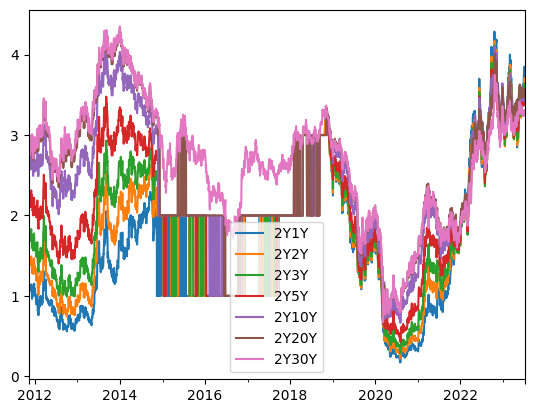

In [32]:
df[[c for c in df.columns if c.startswith('2Y')]].plot()

Let's use `matplotlib` to plot one of the forward rates
* `xticks` allows us to rotates the tick labels on the `x` axis
* `grid` does what it says on the tin
* `xlabel` and `ylabel` add labels to the respective axes
* the semi-colon at the end hides text output from `plt`

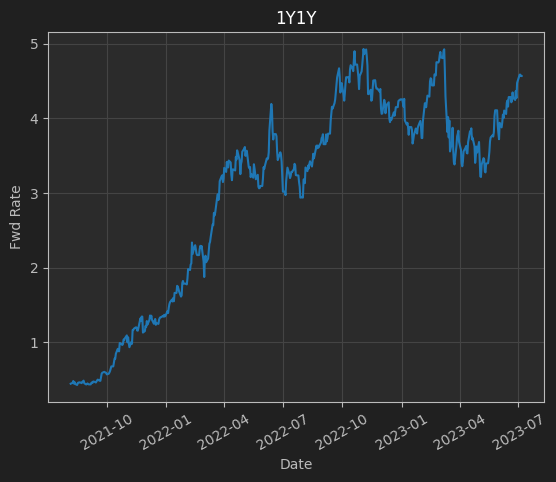

In [8]:
fwd = '1Y1Y'
plt.style.use('custom.mplstyle')
with plt.style.context('custom.mplstyle'):
    plt.plot(df[fwd][-500:])
    plt.title(label=fwd)
    plt.xticks(rotation=30)
    plt.xlabel('Date')
    plt.ylabel('Fwd Rate');

Next let's build a couple of helper functions so that we can sort fwds by either their expiry or tenor length.  We won't get too carried away by daycounts, but rather treat years as integers and months as twelfths of a year.

In [9]:
pattern = r'(\d+)([my])(\d+)y'
exptenor = re.compile(pattern, flags=re.IGNORECASE)

def period(fwd: str, is_expiry: bool = True) -> float:
    mo = re.search(exptenor, fwd)  # match object
    if is_expiry:
        return float(mo[1]) if mo[2].lower() == 'y' else float(mo[1])/12
    return float(mo[3])

expiry_period = partial(period, is_expiry=True)
tenor_period = partial(period, is_expiry=False)

Now let's get all `n`y tenors ordered from shortest to longest expiry.  Because of the ordering we know that pairs of combinations are also ordered.

By iterating across all pairs we can build a dataframe of all the spreads.

In [10]:
tenor = '5Y'
observations = 500

expiries = sorted(set(col for col in df.columns if col.upper().endswith(tenor)), key=expiry_period)

spreads = pd.DataFrame()
for c1,c2 in itt.combinations(expiries,2):
    spreads[c2 + '-' + c1] = df[c2][-observations:] - df[c1][-observations:]

In [11]:
spreads['1Y5Y-1M5Y'][-1]

-0.42900000000000027

In [12]:
spreads.describe()

,3M5Y-1M5Y,6M5Y-1M5Y,1Y5Y-1M5Y,2Y5Y-1M5Y,3Y5Y-1M5Y,4Y5Y-1M5Y,5Y5Y-1M5Y,7Y5Y-1M5Y,10Y5Y-1M5Y,15Y5Y-1M5Y,...,10Y5Y-7Y5Y,15Y5Y-7Y5Y,20Y5Y-7Y5Y,30Y5Y-7Y5Y,15Y5Y-10Y5Y,20Y5Y-10Y5Y,30Y5Y-10Y5Y,20Y5Y-15Y5Y,30Y5Y-15Y5Y,30Y5Y-20Y5Y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.003414,-0.024748,-0.079854,-0.129616,-0.118076,-0.083298,-0.035946,0.051002,0.129632,-0.039764,...,0.078630,-0.090766,-0.539344,-1.042158,-0.169396,-0.617974,-1.120788,-0.448578,-0.951392,-0.502814
std,0.054052,0.132445,0.266052,0.399260,0.447326,0.467212,0.473226,0.468939,0.460901,0.546442,...,0.048625,0.137508,0.277499,0.416993,0.144780,0.289690,0.441677,0.193704,0.351680,0.203216
min,-0.086000,-0.217000,-0.465000,-0.761000,-0.853000,-0.877000,-0.860000,-0.829000,-0.789000,-1.060000,...,-0.082000,-0.531000,-1.098000,-1.578000,-0.558000,-1.141000,-1.668000,-0.930000,-1.439000,-0.924000
25%,-0.059000,-0.165250,-0.352250,-0.472000,-0.479250,-0.443000,-0.391250,-0.295500,-0.207750,-0.427250,...,0.049000,-0.184500,-0.749000,-1.369500,-0.281250,-0.845250,-1.473000,-0.594250,-1.235250,-0.649000
50%,-0.005500,-0.050000,-0.146000,-0.223500,-0.241000,-0.194000,-0.159000,-0.068500,0.058500,-0.153000,...,0.074000,-0.072000,-0.610000,-1.304500,-0.178000,-0.716000,-1.401000,-0.495000,-1.126000,-0.523000
75%,0.049000,0.115000,0.210000,0.255000,0.267500,0.281000,0.313500,0.373500,0.442000,0.375750,...,0.110000,0.015000,-0.220000,-0.653000,-0.039750,-0.282000,-0.719750,-0.241000,-0.673000,-0.354000
max,0.066000,0.160000,0.349000,0.640000,0.818000,0.926000,0.992000,1.054000,1.111000,1.111000,...,0.233000,0.199000,-0.044000,-0.271000,0.149000,-0.134000,-0.321000,-0.107000,-0.280000,-0.059000


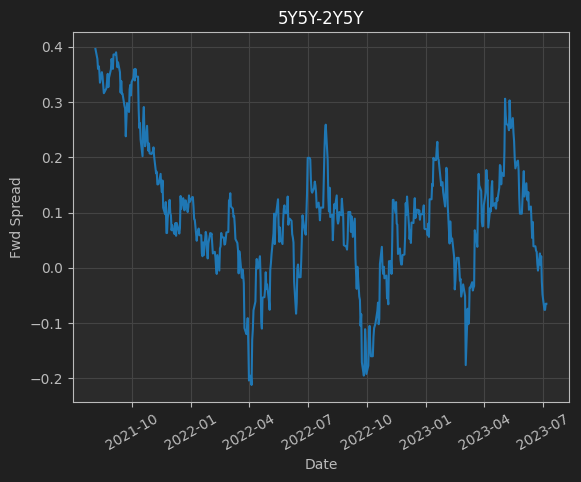

In [13]:
spread = '5Y5Y-2Y5Y'
observations = 500

plt.style.use('custom.mplstyle')
with plt.style.context('custom.mplstyle'):
    plt.plot(spreads[spread][-observations:])
    plt.title(label=spread)
    plt.xticks(rotation=30)
    plt.xlabel('Date')
    plt.ylabel('Fwd Spread')
    plt.show()

In [14]:
def z_score(series, observations = 0):
    mean = np.mean(series[-observations:])
    stdev = np.std(series[-observations:])
    return (series[-1] - mean) / stdev


In [15]:
z_scores = {}
for col in spreads.columns:
    z_scores[col] = z_score(spreads[col],100)

In [16]:
sorted_z_scores = sorted(z_scores.items(), key=lambda x: x[1])
for item in sorted_z_scores[:5] + sorted_z_scores[-5:]:
    print(item)

('20Y5Y-15Y5Y', -2.390132206882358)
('3Y5Y-2Y5Y', -1.6421023141997368)
('4Y5Y-2Y5Y', -1.527285258996592)
('3Y5Y-1M5Y', -1.5092764769103582)
('4Y5Y-1M5Y', -1.506081958858558)
('15Y5Y-5Y5Y', 1.594574101183211)
('30Y5Y-7Y5Y', 1.7342372043650338)
('30Y5Y-10Y5Y', 1.8347152532943314)
('15Y5Y-7Y5Y', 1.9666989145540454)
('15Y5Y-10Y5Y', 2.1204467644512133)


In [17]:
observations = 100
flies = {}
for c1, c2, c3 in itt.combinations(expiries,3):
    fly = 2 * df[c2][-observations:] - df[c1][-observations:] - df[c3][-observations:]
    flies[f'{c1}-{c2}-{c3}'] = z_score(fly)

sorted_flies = sorted(flies.items(), key=lambda x: x[1])
for item in sorted_flies[:5] + sorted_flies[-5:]:
    print(item)

('2Y5Y-5Y5Y-15Y5Y', -2.413393936836477)
('1Y5Y-4Y5Y-15Y5Y', -2.3343882957676754)
('2Y5Y-7Y5Y-15Y5Y', -2.316392342712324)
('3Y5Y-7Y5Y-15Y5Y', -2.3011861292166613)
('1Y5Y-5Y5Y-15Y5Y', -2.2914852726960917)
('3Y5Y-15Y5Y-20Y5Y', 1.9214252762287445)
('4Y5Y-15Y5Y-20Y5Y', 2.1254823116206385)
('5Y5Y-15Y5Y-20Y5Y', 2.2168173571776753)
('7Y5Y-15Y5Y-20Y5Y', 2.294357449018727)
('10Y5Y-15Y5Y-20Y5Y', 2.3115527715053568)


In [18]:
def report_line(series: pd.Series, scale: int = 1) -> str:
    last = series[-1]
    mean = np.mean(series)
    stdev = np.std(series)
    zscore = (last - mean) / stdev
    hvol = scale * np.std(series.diff())
    return last, mean, stdev, zscore, hvol

In [19]:
observations = 100

headers = ['Instrument', 'Last', 'Mean', 'Stdev', 'Z-Score', 'Historic Vol']

with open('report_5y.csv', 'w') as f:
    writer = csv.DictWriter(f, headers)
    writer.writeheader()
    
    # fwds
    for c in expiries:
        series = df[c][-observations:]
        d = dict(zip(headers, [c] + [round(i, 4) for i in report_line(series, 100)]))
        writer.writerow(d)

    # spreads
    for c1, c2 in itt.combinations(expiries,2):
        series = 100 * (df[c2][-observations:] - df[c1][-observations:])
        d = dict(zip(headers, [f'{c2}-{c1}'] + [round(i, 4) for i in report_line(series)]))
        writer.writerow(d)

    # flies
    for c1, c2, c3 in itt.combinations(expiries,3):
        series = 100 * (2 * df[c2][-observations:] - df[c1][-observations:] - df[c3][-observations:])
        d = dict(zip(headers, [f'{c1}-{c2}-{c3}'] + [round(i, 4) for i in report_line(series)]))
        writer.writerow(d)


In [20]:
pca = PCA(n_components=3)
pca.fit(df)

PCA(n_components=3)

In [21]:
pca.explained_variance_ratio_

array([0.68893975, 0.25688361, 0.01846302])

In [22]:
pca.singular_values_

array([384.94031352, 235.05580119,  63.01647999])

In [23]:
pca.components_

array([[-0.06633232, -0.06826421, -0.07361145, -0.08384868, -0.09583904,
        -0.11127905, -0.09203187, -0.07737385, -0.08513306, -0.0908224 ,
        -0.10044184, -0.11312455, -0.11516453, -0.09907799, -0.09142835,
        -0.09802752, -0.10361407, -0.11079172, -0.11807017, -0.11806974,
        -0.11412896, -0.10529293, -0.11029083, -0.11411107, -0.11833927,
        -0.12292453, -0.11966769, -0.11519686, -0.1159977 , -0.11869129,
        -0.11954575, -0.12219179, -0.12561395, -0.12003729, -0.1153764 ,
        -0.12226604, -0.12366151, -0.12505559, -0.12648182, -0.12472403,
        -0.1181864 , -0.1128165 , -0.12844023, -0.12814123, -0.12783026,
        -0.12787669, -0.12331053, -0.11586612, -0.10973207, -0.12150487,
        -0.12037762, -0.11932733, -0.11715916, -0.11264218, -0.09467361,
        -0.0918334 , -0.10886576, -0.10822634, -0.10729293, -0.10571957,
        -0.10105697, -0.09660687, -0.09487787, -0.09597014, -0.09531709,
        -0.09448816, -0.09299274, -0.08975432, -0.0

In [24]:
for component in pca.components_:
    print(len(component))

91
91
91


In [25]:
df.describe()

,1Y1Y,1Y2Y,1Y3Y,1Y5Y,1Y10Y,1Y20Y,1Y30Y,2Y1Y,2Y2Y,2Y3Y,...,3M10Y,3M20Y,3M30Y,6M1Y,6M2Y,6M3Y,6M5Y,6M10Y,6M20Y,6M30Y
count,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,...,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000
mean,1.510414,1.624348,1.751884,1.991379,2.370851,2.424704,2.303483,1.576267,1.730725,1.867298,...,2.132292,2.417163,2.436894,1.333339,1.403632,1.513745,1.766226,2.169341,2.439073,2.451288
std,1.136817,1.004489,0.909495,0.795372,0.727809,0.792516,0.680465,0.892493,0.832372,0.789093,...,0.775018,0.775568,0.760455,1.265182,1.099800,0.984812,0.849256,0.774513,0.778216,0.763127
min,0.145000,0.163000,0.200000,0.315000,0.582000,0.699000,0.670000,0.173000,0.223000,0.284000,...,0.524000,0.688000,0.667000,0.166000,0.159000,0.180000,0.274000,0.543000,0.691000,0.668000
25%,0.617000,0.832250,1.068500,1.387000,1.863000,2.000000,2.000000,1.000000,1.000000,1.242500,...,1.691250,2.000000,2.000000,0.434000,0.652000,0.884250,1.049000,1.739000,2.000000,2.000000
50%,1.176000,1.440000,1.662000,2.026000,2.397000,2.156000,2.000000,1.340000,1.739000,2.000000,...,2.000000,2.440000,2.506000,0.980000,1.000000,1.243500,1.776500,2.018500,2.480000,2.545000
75%,2.060500,2.111000,2.173750,2.427750,2.967000,3.000000,3.000000,2.000000,2.164750,2.426000,...,2.734000,3.000000,3.000000,1.848750,2.000000,2.000000,2.052000,2.789750,3.000000,3.000000
max,4.930000,4.598000,4.421000,4.255000,4.174000,4.090000,4.000000,4.285000,4.169000,4.115000,...,4.256000,4.169000,3.991000,5.688000,4.992000,4.648000,4.405000,4.231000,4.144000,4.042000
